# Introduction  `fb-Prophet`

**`fbprophet`** in this notebook we are testing the parameters that are used in fb prophet

## Key Features
        
- **Growth Detection:** Detecting growth using custom method Ex: linear or Logistic  

- **Automatic Changepoint Detection:** Using Pelt algo to detect changepoints.

- **Generating Ramadan Days:** Using a Hijri Converter fn to generate Ramadan Days between two years

- **Seasonality Modeling:** Experimenting various types of seasonality, such as yearly, weekly, and daily patterns and Ramadan.

- **Holidays and Special Events:** Adding Ramadan as a special Holiday to include the Ramadan effect.

- **Additional Regressors:** 
- **Multiplicative Seasonality:** specify custom trend components
- **Outliers:** Using traditional stat method 
- **Cross Validation:** 
- **Hyperparameter tuning:** 
- **Generate future dates:** 


### Installation
To use `fbprophet`, you need to install it first. You can install it using the following command:

- pip install Prophet
- pip install pelt
- pip install ruptures
- pip install math
- pip install holidays
- pip install hijri_converter

### Importing Libraries

In [320]:
import pandas as pd
import numpy as np
from prophet import Prophet
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
warnings.filterwarnings("ignore")

### Importing Data

In [326]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})
data = data[['ds', 'y']]

In [344]:
# Set parameters
determineGrowth = True
mcmc_samples = 0
interval_width = 0.95
country_name = 'SA'
customholidays_df = pd.DataFrame({'ds': [], 'holiday': []})
holidays_prior_scale = 0.25
seasonality_mode = 'multiplicative'
yearly_seasonality = False
weekly_seasonality = False
daily_seasonality = False

monthly_season = 'monthly'
monthly_season_period = 30.5
monthly_season_fourier_order = 10

ramadan_season = 'Monthly_Ramadan_season'
ramadan_period = 30
ramadan_fourier_order = 10

weekend_days = [4]  # 4 is Friday

# Changepoints
# changepoints: Pelt is generating better results
changepoint_prior_scale = 0.10  # How flexible the changepoints are allowed to be, high it will be more flexible, can lead to overfitting also (ex: 10,30)
# n_changepoints
# changepoint_range

PenaltySensitivity = "High"
pltModelType = "l2"  # "l2", "rbf"
IQRRange = 1.5

# Create a Prophet model with flexible parameters
prophet_params = {
    'growth': 'linear' if determineGrowth else None,
    'mcmc_samples': mcmc_samples,
    'interval_width': interval_width,
    'custom_holidays': customholidays_df if not customholidays_df.empty else None,
    'holidays_prior_scale': holidays_prior_scale,
    'seasonality_mode': seasonality_mode,
    'changepoint_prior_scale': changepoint_prior_scale
}

# Remove parameters with value None
prophet_params = {key: value for key, value in prophet_params.items() if value is not None}


In [345]:
prophet_params

{'growth': 'linear',
 'mcmc_samples': 0,
 'interval_width': 0.95,
 'holidays_prior_scale': 0.25,
 'seasonality_mode': 'multiplicative',
 'changepoint_prior_scale': 0.1}

13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


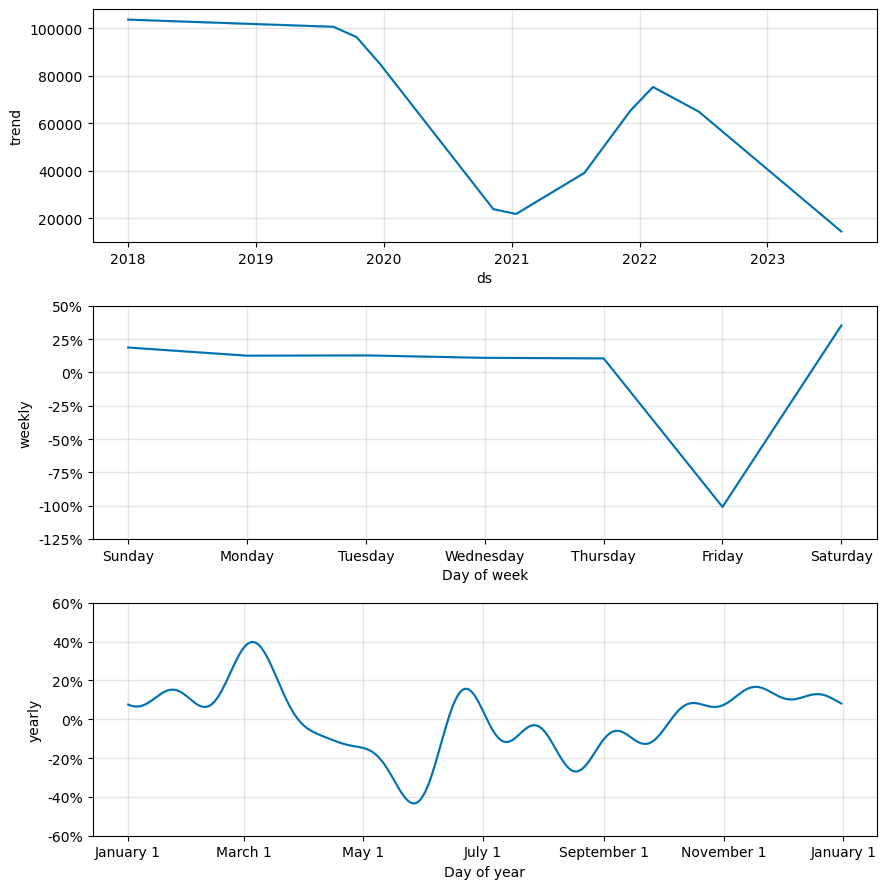

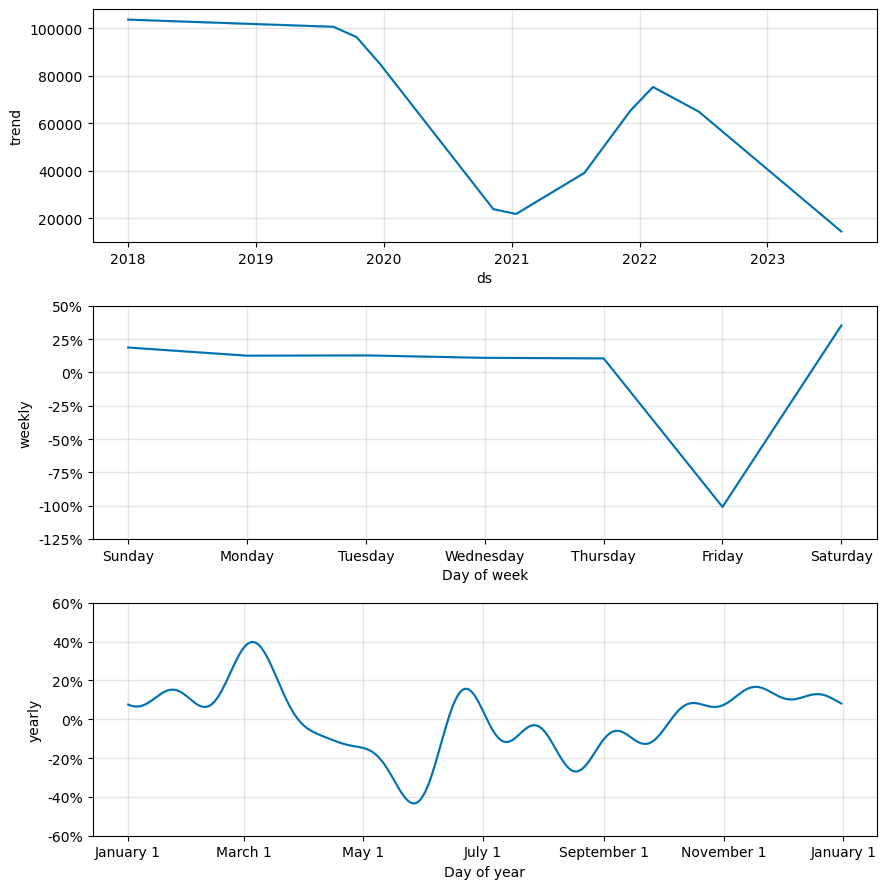

In [346]:
# Create the Prophet model with the filtered parameters
prophetModel = Prophet(**prophet_params)

# Fit the model to the data
prophetModel.fit(data)

prophetModel.plot_components(prophetModel.predict(data))

### Parameter 1: Growth

In [21]:
# Function to decide whether data['y'] is logistic or linear

def detect_growth_pattern(data, curvature_threshold=0.1):
    # Calculate second derivative (curvature)
    curvature = np.gradient(np.gradient(data))
    # Check if the curvature is close to zero
    if np.abs(np.mean(curvature)) <= curvature_threshold:
        return 'linear'
    else:
        return 'logistic'

### Parameter 1.1: Growth (Carrying Capacity and Floor)

In [22]:
# Detect growth pattern
growth = detect_growth_pattern(data['y'])

# Define a percentile value (e.g., 99th percentile)
percentile_value = 99

# Calculate the specified percentile for the cap
cap = (np.percentile(data['y'], percentile_value)) * 1.5

# Define a lower percentile value (e.g., 5th percentile) for the floor
percentile_floor = 5

# Calculate the specified percentile for the floor
floor = np.percentile(data['y'], percentile_floor)
#floor and cap can be used while predicting we need to add them in future_dataframe'

### Parameter 2: Change points PELT Algo

In [23]:
def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

In [32]:
peltdata = data['y'].values
# You can choose between "l1" and "l2" cost functions
model = "l1"  

algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(peltdata) 
penalty= calculate_penalty(peltdata, "Medium") 
result = algo.predict(pen=3) 

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])

In [36]:
#Fitting Prophet Modell with changepointDates
model = Prophet(changepoints=changepointDates['ds'])
model.fit(data)

09:34:53 - cmdstanpy - INFO - Chain [1] start processing
09:34:55 - cmdstanpy - INFO - Chain [1] done processing


## Parameter 3: Seasonality
### Import Country Inbuilt holidays

In [ ]:
#country_code = 'SA'  
model = Prophet(growth=growth)
model.add_country_holidays(country_name='SA')
model.fit(data)

### Import Custom Holidays

In [26]:
from datetime import date
import holidays
for date, name in sorted(holidays.SA(years=2024).items()):
    print(date, name)

2024-02-22 Founding Day Holiday
2024-04-10 Eid al-Fitr Holiday* (*estimated)
2024-04-11 Eid al-Fitr Holiday* (*estimated)
2024-04-12 Eid al-Fitr Holiday* (*estimated)
2024-04-13 Eid al-Fitr Holiday* (*estimated)
2024-04-14 Eid al-Fitr Holiday* (*estimated) (observed)
2024-04-15 Eid al-Fitr Holiday* (*estimated) (observed)
2024-06-15 Arafat Day* (*estimated)
2024-06-16 Eid al-Adha Holiday* (*estimated)
2024-06-17 Eid al-Adha Holiday* (*estimated)
2024-06-18 Eid al-Adha Holiday* (*estimated)
2024-06-19 Eid al-Adha Holiday* (*estimated) (observed)
2024-09-23 National Day Holiday


### Generate the Ramdan Days

In [5]:
import pandas as pd
from hijri_converter import convert

def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    df = pd.DataFrame({'ramadan_dates': ramadan_dates})

    return df

# Example usage:
start_year = 2024
end_year = 2030
ramadan_dates_df = generate_ramadan_dates_df(start_year, end_year)
ramadan_dates_df.head(2)

,ramadan_dates
0,2024-03-11
1,2024-03-12


## Parameter 3.1: Seasonality with fourier Order

In [ ]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=6).fit(data)
a = plot_yearly(m)

In [ ]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(data)
a = plot_yearly(m)

In [ ]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=100).fit(data)
a = plot_yearly(m)

## Add Custom Sesonality

- Default: Yearly and Weekly Prophet will fit, min two cycles (2 years, 2months) needed. <br>
- if daily data with time--> Fit Sub Daily Time Series <br>
- If you need Monthly, Quarterly, Hourly-->    add_seasonality 
- Fourier Order, default: Weekly:3, Yearly =10

In [ ]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#forecast = m.fit(data).predict(future)
m

In [ ]:
#if holidday param is overfiiting, to reduce the effect make  holidays_prior_scale=0.05 as low to reduce its effect.
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)

In [ ]:
#adding custom Seasonality
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)

In [ ]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

## Seasonalities that depend on other factors
Seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays

## Ramadan Seasonality

#### Adding Ramadan Season in the Training and Future Predictions as well

- Create a Custom Monthly Season
- Monthly season with ramdan
- Monthly season without Ramadan

In [ ]:
m = Prophet(weekly_seasonality=False)
#Need to figure out to declare Ramadan as a monthly season
#Need to figure to decalre Months as a Monthly seasons

m.add_seasonality(name='Monthly_Ramadan_season', period=30.5, fourier_order=3, condition_name='Ramadan_season')


#For Predictions we must consider to generate the dates even in future dataframe mentioning Ramadan and Non Ramadan

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

### Dampen the effect of Ramadan or any seasonality
- If Seasonality is overfitting, We can fix it using
- holidays_prior_scale=0.05 
- default holidays_prior_scale 10, reducing it will reduce holiday effect
- m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
- Param
- Seasonality_prior_scale , holidays_prior_scale, prior_scale

In [ ]:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
#For Individual Holidays it can be set

### Additional Regressors
- Regressor value will need to be present in both the fitting and prediction dataframes
- Extra-regressors to the model using the add_regressor method
- The seasonality grows with the trend. 
- This is multiplicative seasonality.Time series has a clear yearly cycle but its growing

In [ ]:
m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)
forecast = m.predict(future)

### Multiplicative Seasonality

In [ ]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from scipy.signal import find_peaks

# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupQuantity': 'y'})
data = data[['ds', 'y']]

## Outliers

In [ ]:
# Assuming you have calculated Q1, Q3, IQR, lower_bound, and upper_bound
# as per the previous snippet
Q1 = data['y'].quantile(0.25)
Q3 = data['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Identifying outliers
outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Replace outlier values with the mean
data.loc[outliers.index, 'y'] = data['y'].mean()

# Optional: Print the updated DataFrame
print(data)

## Cross Validation

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

In [ ]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Hyperparameter tuning

import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

### Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

### Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

### Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# Generate future dates

### Generate future dates
future_dates = model.make_future_dataframe(periods=30)

### Generate predictions
forecast = model.predict(future_dates)

### Analyze and visualize results
print(forecast[['ds', 'yhat']].tail(30))  # View predicted values for the next 30 days
model.plot(forecast)

### Calculate MAE (optional)
mae = np.mean(np.abs(forecast['yhat'] - forecast['y']))
print(f"Mean Absolute Error: {mae:.2f}")

## Checking the Range as well

forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#### Extract predicted values for the next 30 days
predicted_values_prophet = forecast_prophet[['ds', 'yhat']].tail(30)

#### Export the predicted values to a CSV file
predicted_values_prophet.to_csv('/home/ajaz/DemandForecasting/Data/Output/output_prophet.csv', index=False)

fig1 = m.plot(forecast_prophet)

fig2 = m.plot_components(forecast_prophet)

from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast_prophet)

plot_components_plotly(m, forecast_prophet)

# Checking the Fitting Vs Actual Data

from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')

# Prepare the data for Prophet
prophet_data = data.rename(columns={'TransactionDate': 'ds', 'GroupQuantity': 'y'})

# Initialize Prophet
m = Prophet()

# Fit the model
m.fit(prophet_data)

# Make predictions on the training data
forecast = m.predict(prophet_data)

# Convert 'ds' column to proper datetime format
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Visualize training data vs. predictions
plt.figure(figsize=(10, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training Data vs. Predictions')
plt.show()


from prophet import Prophet
import pandas as pd

# Load your dataset
data = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')

# Prepare the data for Prophet
prophet_data = data.rename(columns={'TransactionDate': 'ds', 'GroupQuantity': 'y'})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])  # Convert 'ds' to datetime

# Initialize Prophet
m = Prophet()

# Fit the model
m.fit(prophet_data)

# Make predictions on the training data (fitted values)
forecast = m.predict(prophet_data)

# Extract actual values and fitted values
actual_values = prophet_data[['ds', 'y']]
fitted_values = forecast[['ds', 'yhat']]

# Merge actual and fitted values into a single DataFrame
result = pd.concat([actual_values.set_index('ds'), fitted_values.set_index('ds')], axis=1)
result.columns = ['y_actual', 'yhat_fitted']

# Reset index to have 'ds' as a column
result.reset_index(inplace=True)

# Export the values to a CSV file
result.to_csv('/home/ajaz/DemandForecasting/Data/Output/actual_vs_fitted_values.csv', index=False)


result